# Bike Sharing Demand

ou are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

### Data Fields
* datetime - hourly date + timestamp  
* season
    * 1 = spring
    * 2 = summer
    * 3 = fall
    * 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [13]:
############### utility function ##############


    


In [72]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [7]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [68]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### 예측 target = `count` 변수
* `count` = `casual` (미가입자 이용) + `registered` (가입자 이용)
* `casual`과 `registered`를 각각 예측하여, 예측값을 합산하는 형태에 대한 고려 필요함.

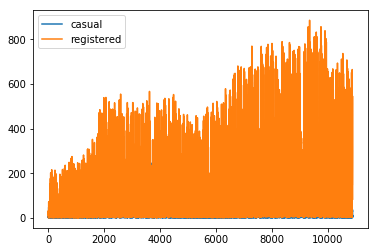

In [74]:
train[['casual', 'registered']].plot(kind);plt.show()

In [22]:
# 11년 1월 1일 00시부터 12년 12월 19일 23시까지의 데이터
# 각 행은 1시간 단위로 기록되었음.
# 매월 데이터는 1일부터 19일까지만 포함됨.

train['datetime'][0], list(train['datetime'])[-1]

('2011-01-01 00:00:00', '2012-12-19 23:00:00')

## Data Investigation & Visualization

* 온도/체감온도 박스플롯

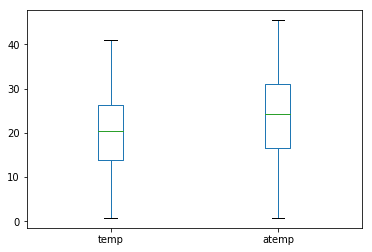

In [36]:
train[['temp', 'atemp']].plot(kind='box');plt.show()

In [40]:
train_temp_spring = train[train['season']==1]['temp']
train_temp_summer = train[train['season']==2]['temp']
train_temp_fall = train[train['season']==3]['temp']
train_temp_winter = train[train['season']==4]['temp']

In [45]:
train_temp_summer

1323    10.66
1324    10.66
1325    10.66
1326     9.84
1327     9.84
1328     9.84
1329     9.84
1330     9.84
1331    10.66
1332    13.12
1333    13.12
1334    13.12
1335    13.94
1336    14.76
1337    14.76
1338    13.94
1339    13.94
1340    13.94
1341    13.94
1342    13.94
1343    13.12
1344    13.12
1345    12.30
1346    12.30
1347    12.30
1348    10.66
1349     9.84
1350     9.84
1351     9.84
1352     9.84
        ...  
8121    25.42
8122    25.42
8123    25.42
8124    25.42
8125    25.42
8126    24.60
8127    24.60
8128    24.60
8129    24.60
8130    24.60
8131    24.60
8132    24.60
8133    24.60
8134    24.60
8135    24.60
8136    26.24
8137    26.24
8138    27.06
8139    28.70
8140    30.34
8141    31.16
8142    31.98
8143    32.80
8144    32.80
8145    32.80
8146    32.80
8147    32.80
8148    31.16
8149    29.52
8150    29.52
Name: temp, Length: 2733, dtype: float64

* 계절별 온도 boxplotting
  * 겨울 < 봄 < 여름 < 가을 순으로 온도 높음

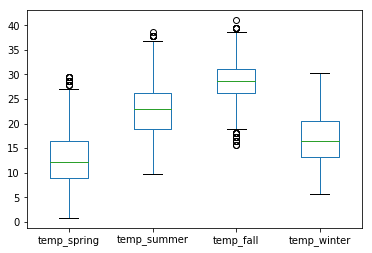

In [63]:
pd.concat([train_temp_spring.reset_index(name='temp_spring'),
          train_temp_summer.reset_index(name='temp_summer'),
          train_temp_fall.reset_index(name='temp_fall'),
          train_temp_winter.reset_index(name='temp_winter')], 
          axis=1).drop(['index', 'index', 'index', 'index'], axis=1).plot(kind='box');plt.show()

* 계절별 자전거 총 대여횟수는 온도에 비례하여 높은 것으로 나타남

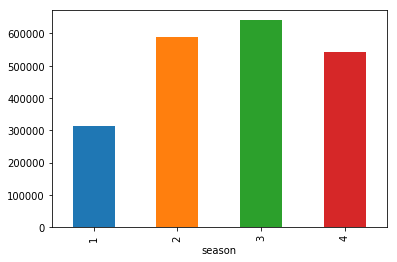

In [67]:
train.groupby('season')['count'].sum().plot(kind='bar');plt.show()

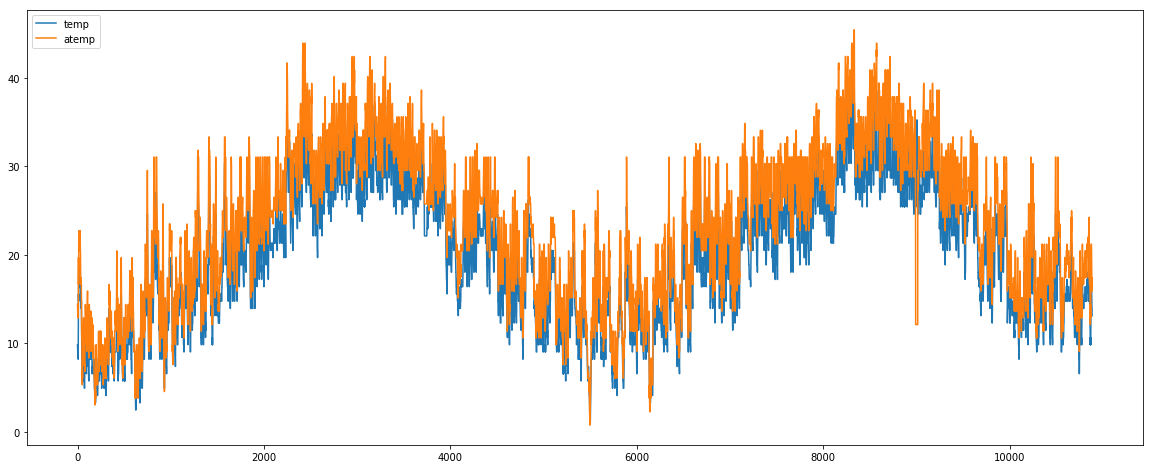

In [28]:
# 온도/ 체감온도

plt.figure(figsize=(20,8));train['temp'].plot();train['atemp'].plot()
plt.legend(loc='upper left')
plt.show()

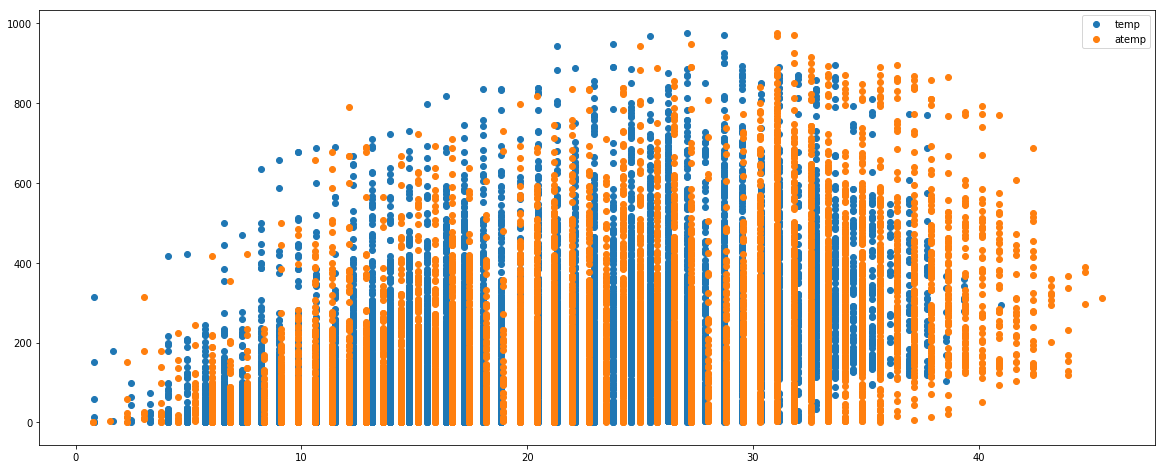

In [32]:
# 온도/체감온도는 시간별 자전거 대여량과 유의미한 상관성을 가진 것으로 나타남.

plt.figure(figsize=(20,8))
plt.scatter(train['temp'], train['count'])
plt.scatter(train['atemp'], train['count'])
plt.legend(['temp', 'atemp'])
plt.show()

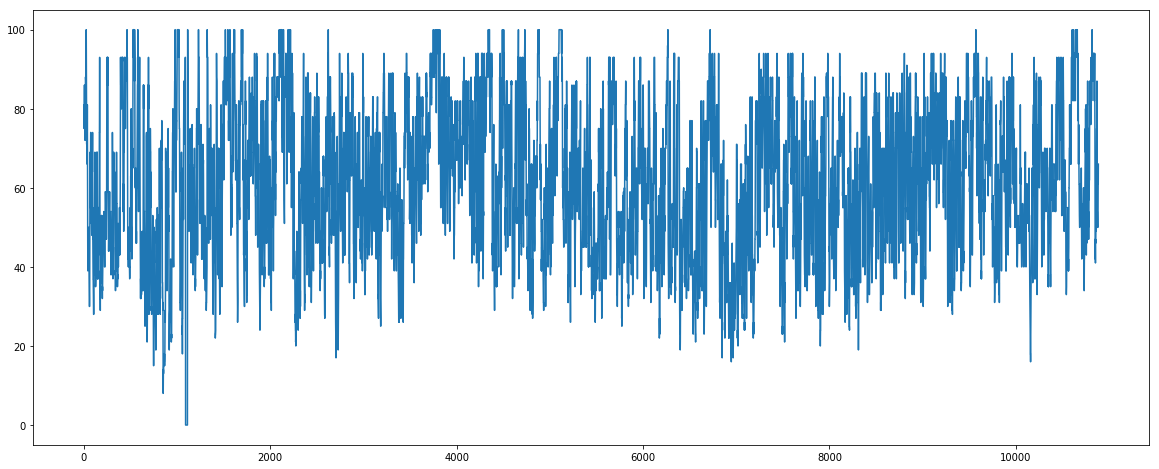

In [26]:
# 습도
plt.figure(figsize=(20,8));train['humidity'].plot();plt.show()

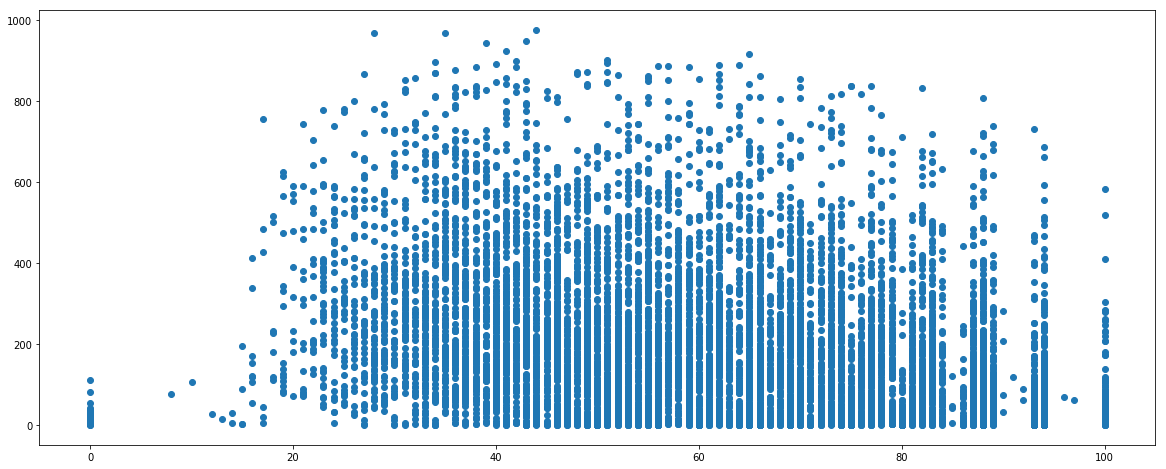

In [33]:
plt.figure(figsize=(20,8))
plt.scatter(train['humidity'], train['count'])
plt.show()

In [15]:
train['season'].

10886

In [20]:
# 총 10886개의 data row 중, 
# holiday에 해당하는 row = 311개
# workingday에 해당하는 row = 7412개

train['holiday'].count(), train['holiday'].sum(), train['workingday'].sum()

(10886, 311, 7412)

## Feature Engineering

In [8]:
# convert datetime column to datetime data format

